In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm


# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_simu'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.tsv', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {'common_common' : '#78ADD2', 'common' : '#78ADD2', 'common_lf' : '#80C680',
             'lf_lf' : '#FFB26E', 'lf' : '#FFB26E'}
MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_annot=45
n_pannot=34


In [3]:
# LDSPEC results
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/simulation.100123'
DIC_RES_PATH = {}

DIC_RES_PATH['null_h2g50_p20'] = {
    'truth' : DATA_PATH + '/null_h2g50_p20/rep@',
    'md_prox_gene_fct_all_ld_1e6' : DATA_PATH + '/null_h2g50_p20.prox_gene_fct_all_ld_1e6/rep@',
    'md_prox_gene_fct_all_ld_3e6' : DATA_PATH + '/null_h2g50_p20.prox_gene_fct_all_ld_3e6/rep@',
    'md_prox_gene_fct_all_ld_5e6' : DATA_PATH + '/null_h2g50_p20.prox_gene_fct_all_ld_5e6/rep@',
    'md_prox_gene_fct_all_ld_1e7' : DATA_PATH + '/null_h2g50_p20.prox_gene_fct_all_ld/rep@',
}

DIC_RES_PATH['causal_h2g50_p20'] = {
    'truth' : DATA_PATH + '/causal_h2g50_p20/rep@',
    'md_prox_gene_fct_all_ld_1e6' : DATA_PATH + '/causal_h2g50_p20.prox_gene_fct_all_ld_1e6/rep@',
    'md_prox_gene_fct_all_ld_3e6' : DATA_PATH + '/causal_h2g50_p20.prox_gene_fct_all_ld_3e6/rep@',
    'md_prox_gene_fct_all_ld_5e6' : DATA_PATH + '/causal_h2g50_p20.prox_gene_fct_all_ld_5e6/rep@',
    'md_prox_gene_fct_all_ld_1e7' : DATA_PATH + '/causal_h2g50_p20.prox_gene_fct_all_ld/rep@',
}

In [4]:
dic_res = {}
dic_n_rep = {}

for simu in DIC_RES_PATH:
    dic_n_rep[simu] = 0
    for i_rep in range(100):
        if os.path.exists(DIC_RES_PATH[simu]['truth'].replace('@','%d'%i_rep)+'.sumstats.gz'):
            dic_n_rep[simu] = i_rep + 1
        else:
            break           
        
    dic_res[simu] = {}
    for i_rep in range(dic_n_rep[simu]):
        dic_res[simu][i_rep] = {}
        for md in DIC_RES_PATH[simu]:
            dic_res[simu][i_rep][md] = {}
            if md == 'truth':
                for res in ['tau', 'omega']:
                    dic_res[simu][i_rep]['truth'][res] = pd.read_csv(
                        DIC_RES_PATH[simu]['truth'].replace('@','%d'%i_rep)+'.eff_%s.tsv' % res, 
                        sep='\t', index_col=0
                    )
            else:
                if os.path.exists(DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.tau.tsv') is False:
                    print('Missing: ', DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.tau.tsv')
                    continue
                for res in ['tau', 'omega']:                
                    dic_res[simu][i_rep][md][res] = pd.read_csv(
                        DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.%s.tsv' % res, sep='\t', index_col=0
                )
    
    # Print h2
    for md in DIC_RES_PATH[simu]:
        if md=='truth': 
            continue
        v_ = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2'] for x in range(dic_n_rep[simu])])
        v_se = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2_se'] for x in range(dic_n_rep[simu])])
        v_true = np.array([dic_res[simu][0]['truth']['tau'].loc['AN:all', 'h2'] for x in range(dic_n_rep[simu])])
        print('%-20s n_rep=%d \t %-20s h2=%0.3f, h2_true=%0.3f, avg_jnse=%0.3f, empi_se=%0.3f' %(
            simu, dic_n_rep[simu], md, np.mean(v_), np.mean(v_true), np.mean(v_se), np.std(v_)
        ))

null_h2g50_p20       n_rep=50 	 md_prox_gene_fct_all_ld_1e6 h2=0.624, h2_true=0.496, avg_jnse=0.023, empi_se=0.018
null_h2g50_p20       n_rep=50 	 md_prox_gene_fct_all_ld_3e6 h2=0.530, h2_true=0.496, avg_jnse=0.019, empi_se=0.016
null_h2g50_p20       n_rep=50 	 md_prox_gene_fct_all_ld_5e6 h2=0.515, h2_true=0.496, avg_jnse=0.019, empi_se=0.015
null_h2g50_p20       n_rep=50 	 md_prox_gene_fct_all_ld_1e7 h2=0.507, h2_true=0.496, avg_jnse=0.018, empi_se=0.015
causal_h2g50_p20     n_rep=50 	 md_prox_gene_fct_all_ld_1e6 h2=0.458, h2_true=0.354, avg_jnse=0.019, empi_se=0.013
causal_h2g50_p20     n_rep=50 	 md_prox_gene_fct_all_ld_3e6 h2=0.388, h2_true=0.354, avg_jnse=0.016, empi_se=0.011
causal_h2g50_p20     n_rep=50 	 md_prox_gene_fct_all_ld_5e6 h2=0.376, h2_true=0.354, avg_jnse=0.015, empi_se=0.011
causal_h2g50_p20     n_rep=50 	 md_prox_gene_fct_all_ld_1e7 h2=0.370, h2_true=0.354, avg_jnse=0.015, empi_se=0.010


### Comparison

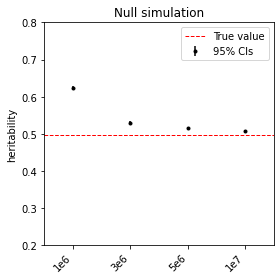

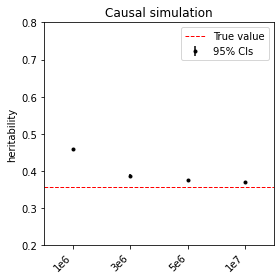

In [5]:
# h2 of AN:all
md_list = [
    'md_prox_gene_fct_all_ld_1e6', 'md_prox_gene_fct_all_ld_3e6', 
    'md_prox_gene_fct_all_ld_5e6', 'md_prox_gene_fct_all_ld_1e7',
]
for simu in ['null_h2g50_p20', 'causal_h2g50_p20']:
    N_REP = dic_n_rep[simu]
    df_plot = pd.DataFrame(index=md_list, columns=['mean', 'se', 'mean.true'], dtype=float)
    for md in md_list:
        v_ = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2'] for x in range(N_REP)])
        v_se = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2_se'] for x in range(N_REP)])
        v_true = np.array([dic_res[simu][x]['truth']['tau'].loc['AN:all', 'h2'] for x in range(N_REP)])

        df_plot.loc[md] = [np.mean(v_), np.std(v_)/np.sqrt(N_REP), np.mean(v_true)]

    plt.figure(figsize=[4,4])
    plt.errorbar(np.arange(df_plot.shape[0]), df_plot['mean'], yerr=df_plot['se']*1.96, 
                 fmt= '.', color='k', label='95% CIs', zorder=10)
    true_val = df_plot.loc[md_list[0], 'mean.true']
    plt.plot([-0.5, df_plot.shape[0]-0.5], [true_val, true_val], 
             "--", linewidth=1, zorder=0, color='r', label='True value')
    plt.legend()
    
    plt.title('%s simulation' % simu.split('_')[0].capitalize())
    plt.xlim([-0.5, df_plot.shape[0]-0.5])
    plt.ylim([0.2, 0.8])
    plt.ylabel(DIC_NAME['h2'])
    plt.xticks(np.arange(df_plot.shape[0]), [x.split('_')[-1] for x in df_plot.index], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/winsize_h2.%s.pdf' % simu)
    plt.show()

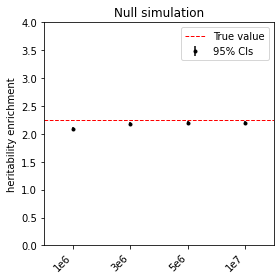

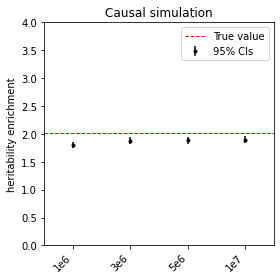

In [6]:
# h2_enrich of AN:Enhancer_Hoffman_common
md_list = [
    'md_prox_gene_fct_all_ld_1e6', 'md_prox_gene_fct_all_ld_3e6', 
    'md_prox_gene_fct_all_ld_5e6', 'md_prox_gene_fct_all_ld_1e7',
]
for simu in ['null_h2g50_p20', 'causal_h2g50_p20']:
    N_REP = dic_n_rep[simu]
    df_plot = pd.DataFrame(index=md_list, columns=['mean', 'se', 'mean.true'], dtype=float)
    for md in md_list:
        v_ = np.array([dic_res[simu][x][md]['tau'].loc['AN:SuperEnhancer_Hnisz_common', 'h2_enrich']
                       for x in range(N_REP)])
        v_se = np.array([dic_res[simu][x][md]['tau'].loc['AN:SuperEnhancer_Hnisz_common', 'h2_enrich_se']
                         for x in range(N_REP)])
        v_true = np.array([dic_res[simu][x]['truth']['tau'].loc['AN:SuperEnhancer_Hnisz_common', 'h2_enrich']
                           for x in range(N_REP)])

        df_plot.loc[md] = [np.mean(v_), np.std(v_)/np.sqrt(N_REP), np.mean(v_true)]

    plt.figure(figsize=[4,4])
    plt.errorbar(np.arange(df_plot.shape[0]), df_plot['mean'], yerr=df_plot['se']*1.96, 
                 fmt= '.', color='k', label='95% CIs', zorder=10)
    true_val = df_plot.loc[md_list[0], 'mean.true']
    plt.plot([-0.5, df_plot.shape[0]-0.5], [true_val, true_val], 
             "--", linewidth=1, zorder=0, color='r', label='True value')
    plt.legend()
    
    plt.title('%s simulation' % simu.split('_')[0].capitalize())
    plt.xlim([-0.5, df_plot.shape[0]-0.5])
    plt.ylim([0, 4])
    plt.ylabel(DIC_NAME['h2_enrich'])
    plt.xticks(np.arange(df_plot.shape[0]), [x.split('_')[-1] for x in df_plot.index], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/winsize_h2_enrich.%s.pdf' % simu)
    plt.show()

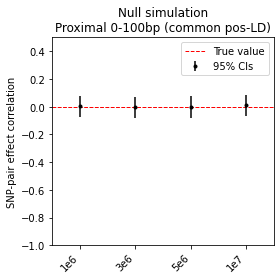

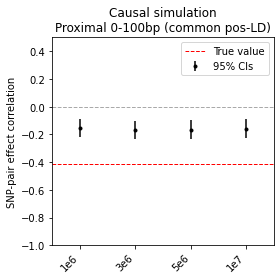

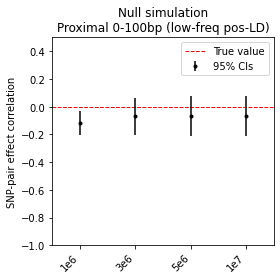

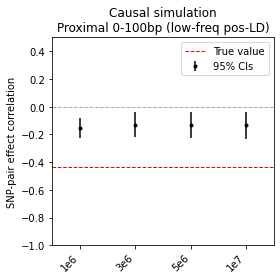

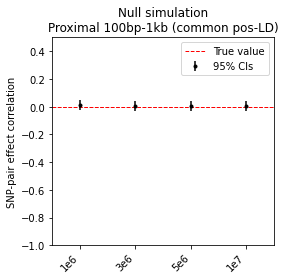

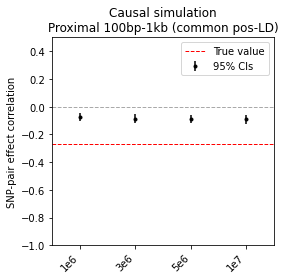

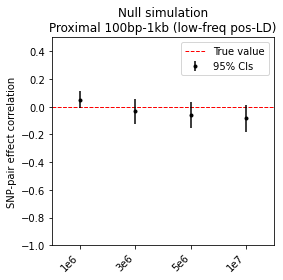

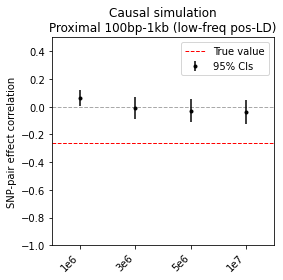

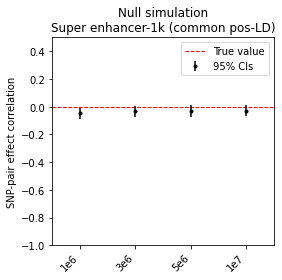

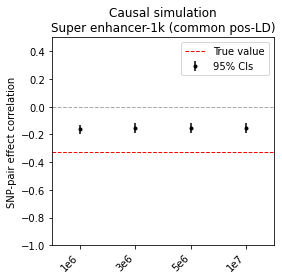

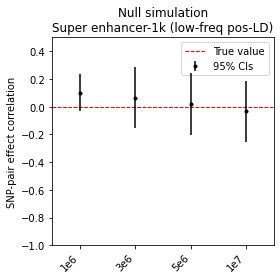

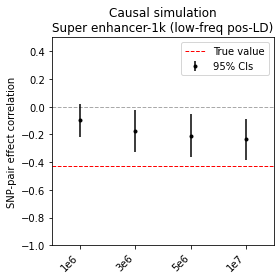

In [7]:
# cor of AN:all across simulation replicates
md_list = [
    'md_prox_gene_fct_all_ld_1e6', 'md_prox_gene_fct_all_ld_3e6', 
    'md_prox_gene_fct_all_ld_5e6', 'md_prox_gene_fct_all_ld_1e7',
]

for pannot in [
    'pAN:proxy_0_100_ld_p0_p100_maf_common_block', 'pAN:proxy_0_100_ld_p0_p100_maf_lf_block',
    'pAN:proxy_100_1000_ld_p0_p100_maf_common_block', 'pAN:proxy_100_1000_ld_p0_p100_maf_lf_block',
    'pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block', 
    'pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block',
]:
    for simu in ['null_h2g50_p20', 'causal_h2g50_p20']:
        N_REP = dic_n_rep[simu]
        df_plot = pd.DataFrame(index=md_list, columns=['mean', 'se', 'mean.true', 'se.true'], dtype=float)
        for md in md_list:
            v_ = np.array([dic_res[simu][x][md]['omega'].loc[pannot, 'cor'] for x in range(N_REP)])
            v_se = np.array([dic_res[simu][x][md]['omega'].loc[pannot, 'cor_se'] for x in range(N_REP)])
            if simu == 'null_h2g50_p20':
                v_true = np.zeros(N_REP)
            else:
                v_true = np.array([dic_res[simu][x]['truth']['omega'].loc[pannot, 'cor'] for x in range(N_REP)])

            df_plot.loc[md] = [np.mean(v_), np.std(v_)/np.sqrt(N_REP), np.mean(v_true), 
                               np.std(v_true)/np.sqrt(N_REP)]

        plt.figure(figsize=[4,4])
        plt.errorbar(np.arange(df_plot.shape[0]), df_plot['mean'], yerr=df_plot['se']*1.96, 
                     fmt= '.', color='k', label='95% CIs', zorder=10)
        plt.plot([-0.5, df_plot.shape[0]-0.5], [0,0], "--", linewidth=1, zorder=0, color='darkgrey')
        true_val = df_plot.loc[md_list[0], 'mean.true']
        plt.plot([-0.5, df_plot.shape[0]-0.5], [true_val, true_val], 
                 "--", linewidth=1, zorder=0, color='r', label='True value')
        plt.legend()

        plt.title('%s simulation\n%s' % (simu.split('_')[0].capitalize(), DIC_NAME[pannot]))
        plt.xlim([-0.5, df_plot.shape[0]-0.5])
        plt.ylim([-1, 0.5])
#         plt.title(DIC_NAME[pannot])
        plt.ylabel(DIC_NAME['cor'])
        plt.xticks(np.arange(df_plot.shape[0]), [x.split('_')[-1] for x in df_plot.index], rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(FIG_PATH + '/winsize_cor.%s.%s.pdf' % (simu, pannot.replace('pAN:', '')))
        plt.show()